# Call Option Benchmarks
Author: JP Melo

### Imports

In [10]:
import torch

DEV = torch.device("cpu")   
torch.set_default_device(DEV)

from derpinns.nn import *
from derpinns.nn import *
from derpinns.utils import *
from derpinns.trainer import *
from nets import *
from optimizer import *
from functools import wraps
import time, torch
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401
from scipy.stats import norm, qmc          
import time
import math
from dataclasses import asdict
import numpy as np
from numba import njit, prange, float64    # jit-compile the inner loop
import itertools


%matplotlib widget

DTYPE = torch.float64

In [2]:
def handle_serialization(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, list):
        return [handle_serialization(item) for item in obj]
    elif isinstance(obj, dict):
        return {k: handle_serialization(v) for k, v in obj.items()}
    elif isinstance(obj, float):
        return float(obj)
    elif isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.float64):
        return float(obj)
    else:
        raise TypeError(f"Type {type(obj)} not serializable")

# ───────────────── timing decorator ────────────────────────────────
def timed(fn):
    """Print wall-time of every call to *fn* (CUDA-synchronised)."""
    @wraps(fn)
    def wrapper(self, *args, **kwargs):
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
        t0 = time.perf_counter()

        out = fn(self, *args, **kwargs)

        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
        dt = (time.perf_counter() - t0) * 1e3
        print(f"[{fn.__name__:<30}] {dt:8.3f} ms")
        return out
    return wrapper
# ───────────────────────────────────────────────────────────────────


class DimlessBS:
    # ─────────────── ctor ──────────────────────────────────────────
    def __init__(self, x, y, mask, n_assets,
                 model, rho, sigma, r,
                 dtype, device):

        self.n_assets = n_assets
        self.sigma, self.r, self.rho = sigma, r, rho
        self.model  = model.to(device, dtype)
        self.y      = y.to(device, dtype)
        self.x      = x.to(device, dtype)
        self.mask   = mask

        self.dtype  = dtype
        self.device = device

    # ─────────────── derivatives ──────────────────────────────────
    @timed
    def compute_derivatives(self, x):
        x = x.requires_grad_(True)
        u = self.model(x)

        g = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_tau = g[:, -1]
        u_x   = g[:, :self.n_assets]

        u_xx = torch.stack([
            torch.autograd.grad(
                u_x[:, j].sum(), x, create_graph=True
            )[0][:, :self.n_assets]
            for j in range(self.n_assets)
        ], dim=1)

        return u, u_tau, u_x, u_xx

    # ─────────────── interior PDE residual (sign fixed) ───────────
    @timed
    def interior_residual(self, u, u_tau, u_x, u_xx):
        diffusion = torch.zeros_like(u_tau)
        drift     = torch.zeros_like(u_tau)

        for i in range(self.n_assets):
            diffusion += 0.5 * self.sigma[i]**2 * u_xx[:, i, i]
            drift     += (self.r - 0.5 * self.sigma[i]**2) * u_x[:, i]
            for j in range(i + 1, self.n_assets):
                diffusion += (self.sigma[i] * self.sigma[j] *
                              self.rho[i, j] * u_xx[:, i, j])

        reaction = self.r * u.squeeze()
        # -------- sign changed here:  -u_tau + diffusion + drift - r u
        return -u_tau + diffusion + drift - reaction

    # ─────────────── top & bottom faces (unchanged) ───────────────
    @timed
    def __top_i_boundary_residual(self, u, u_tau, u_x, u_xx, i):
        drift_sum = (self.r * u_x).sum(-1)

        cross = torch.zeros_like(drift_sum)
        for k in range(self.n_assets):
            for j in range(k + 1, self.n_assets):
                if k != i and j != i:
                    cross += 2 * self.sigma[k] * self.sigma[j] * \
                             self.rho[k, j] * u_xx[:, k, j]

        pure = torch.zeros_like(drift_sum)
        for j in range(self.n_assets):
            if j != i:
                pure += self.sigma[j]**2 * (u_xx[:, j, j] - u_x[:, j])

        return -u_tau + drift_sum + 0.5 * (cross + pure) - self.r * u.squeeze()

    @timed
    def __bottom_i_boundary_residual(self, u, u_tau, u_x, u_xx, i):
        drift_sum = torch.zeros_like(u_tau)
        for j in range(self.n_assets):
            if j != i:
                drift_sum += self.r * u_x[:, j]

        cross = torch.zeros_like(u_tau)
        for k in range(self.n_assets):
            for j in range(k + 1, self.n_assets):
                if k != i and j != i:
                    cross += 2 * self.sigma[k] * self.sigma[j] * \
                             self.rho[k, j] * u_xx[:, k, j]

        pure = torch.zeros_like(u_tau)
        for j in range(self.n_assets):
            if j != i:
                pure += self.sigma[j]**2 * (u_xx[:, j, j] - u_x[:, j])

        return -u_tau + drift_sum + 0.5 * (cross + pure) - self.r * u.squeeze()

    # ─────────────── boundary loss (unchanged) ────────────────────
    @timed
    def boundary_loss(self, u, u_tau, u_x, u_xx):
        losses = torch.zeros(self.n_assets * 2, dtype=self.dtype, device=self.device)

        for i in range(self.n_assets):
            top_mask    = self.mask[:, 2 + 2 * i].bool()
            bottom_mask = self.mask[:, 3 + 2 * i].bool()

            if bottom_mask.any():
                br = self.__bottom_i_boundary_residual(
                        u[bottom_mask], u_tau[bottom_mask],
                        u_x[bottom_mask], u_xx[bottom_mask], i)
                losses[2 * i] = (br ** 2).mean()

            if top_mask.any():
                tr = self.__top_i_boundary_residual(
                        u[top_mask], u_tau[top_mask],
                        u_x[top_mask], u_xx[top_mask], i)
                losses[2 * i + 1] = (tr ** 2).mean()

        return losses

    # ─────────────── initial condition residual ───────────────────
    @timed
    def initial_residual(self, u, y):
        return u - y

    # ─────────────── overall loss ---------------------------------
    @timed
    def compute_losses(self):
        u, u_tau, u_x, u_xx = self.compute_derivatives(self.x)

        # interior
        interior_mask = self.mask[:, 0].bool()
        if interior_mask.any():
            interior = (self.interior_residual(
                            u[interior_mask], u_tau[interior_mask],
                            u_x[interior_mask], u_xx[interior_mask]) ** 2).mean()
        else:
            interior = torch.tensor(0., dtype=self.dtype, device=self.device)

        # initial
        init_mask = self.mask[:, 1].bool()
        if init_mask.any():
            initial = (self.initial_residual(
                           u[init_mask], self.y[init_mask]) ** 2).mean()
        else:
            initial = torch.tensor(0., dtype=self.dtype, device=self.device)

        # boundaries
        boundary = self.boundary_loss(u, u_tau, u_x, u_xx).sum()

        return interior, boundary, initial

    # ─────────────── callable -------------------------------------
    @timed
    def __call__(self, *_, **__):
        interior, boundary, initial = self.compute_losses()
        total = interior + boundary + initial
        print(f"Interior {interior.item():.4e} | "
              f"Boundary {boundary.item():.4e} | "
              f"Initial {initial.item():.4e} | "
              f"Total {total.item():.4e}")
        return total


In [3]:
import time, torch
from functools import wraps

def timed(fn):
    @wraps(fn)
    def wrapper(self, *a, **kw):
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
        t0 = time.perf_counter()
        out = fn(self, *a, **kw)
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
        print(f"[{fn.__name__:<30}] {(time.perf_counter()-t0)*1e3:8.3f} ms")
        return out
    return wrapper

class DimlessBS:
    # ---------------------------------------------------------------
    def __init__(self, x, y, mask, n_assets,
                 model, rho, sigma, r,
                 dtype, device):

        self.n_assets = n_assets

        # ── convert NumPy → torch tensors here ───────────────────
        self.sigma = torch.as_tensor(sigma, dtype=dtype, device=device)  # (d,)
        self.rho   = torch.as_tensor(rho,   dtype=dtype, device=device)  # (d,d)
        self.r     = torch.tensor(r,        dtype=dtype, device=device)

        self.model = model.to(device, dtype)
        self.x     = x.to(device, dtype)
        self.y     = y.to(device, dtype)
        self.mask  = mask

        self.dtype  = dtype
        self.device = device

    # ---------------------------------------------------------------
    def compute_derivatives(self, x):
        x = x.requires_grad_(True)
        u = self.model(x)

        g = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_tau = g[:, -1]
        u_x   = g[:, :self.n_assets]

        u_xx = torch.stack([
            torch.autograd.grad(
                u_x[:, j].sum(), x, create_graph=True
            )[0][:, :self.n_assets]
            for j in range(self.n_assets)
        ], dim=1)
        return u, u_tau, u_x, u_xx

    # ---------------------------------------------------------------
    # ----------  interior residual  --------------------------------
    def interior_residual(self, u, u_tau, u_x, u_xx):
        """  u_tau  -  RHS  of the scaled PDE  """
        diag = 0.5 * (self.sigma ** 2) * (u_xx.diagonal(dim1=1, dim2=2) - u_x)
        diag = diag.sum(-1)                                   # (B,)

        cross = torch.zeros_like(u_tau)
        for i in range(self.n_assets):
            for j in range(i + 1, self.n_assets):
                cross += (self.sigma[i] * self.sigma[j] *
                          self.rho[i, j] * u_xx[:, i, j])
        # the PDE wants ½∑_{i≠j} … , our loop counts each pair once
        cross = 0.5 * cross

        drift = self.r * u_x.sum(-1)                          # (B,)
        reaction = -self.r * u.squeeze(-1)                    # (B,)

        return u_tau - (diag + cross + drift + reaction)

    # ---------------------------------------------------------------
    def __top_i_boundary_residual(self, u, u_tau, u_x, u_xx, k):
        diag = 0.5 * (self.sigma ** 2) * (u_xx.diagonal(dim1=1, dim2=2) - u_x)
        diag = diag.sum(-1) - 0.5 * self.sigma[k]**2 * (u_xx[:, k, k] - u_x[:, k])

        cross = torch.zeros_like(u_tau)
        for i in range(self.n_assets):
            if i == k: continue
            for j in range(i + 1, self.n_assets):
                if j == k: continue
                cross += (self.sigma[i] * self.sigma[j] *
                          self.rho[i, j] * u_xx[:, i, j])
        cross *= 0.5

        drift = self.r * u_x.sum(-1)                          # all i
        reaction = -self.r * u.squeeze(-1)

        return u_tau - (diag + cross + drift + reaction)

    
    def __bottom_i_boundary_residual(self, u, u_tau, u_x, u_xx, k):
        diag = 0.5 * (self.sigma ** 2) * (u_xx.diagonal(dim1=1, dim2=2) - u_x)
        diag = diag.sum(-1) - 0.5 * self.sigma[k]**2 * (u_xx[:, k, k] - u_x[:, k])

        cross = torch.zeros_like(u_tau)
        for i in range(self.n_assets):
            if i == k: continue
            for j in range(i + 1, self.n_assets):
                if j == k: continue
                cross += (self.sigma[i] * self.sigma[j] *
                          self.rho[i, j] * u_xx[:, i, j])
        cross *= 0.5

        drift = self.r * u_x.sum(-1) - self.r * u_x[:, k]     # exclude k
        reaction = -self.r * u.squeeze(-1)

        return u_tau - (diag + cross + drift + reaction)

    # ---------------------------------------------------------------
    def boundary_loss(self, u, u_tau, u_x, u_xx):
        losses = torch.zeros(self.n_assets * 2,
                             dtype=self.dtype, device=self.device)

        for i in range(self.n_assets):
            top_mask    = self.mask[:, 2 + 2*i].bool()
            bottom_mask = self.mask[:, 3 + 2*i].bool()

            if bottom_mask.any():
                br = self.__bottom_i_boundary_residual(
                        u[bottom_mask], u_tau[bottom_mask],
                        u_x[bottom_mask], u_xx[bottom_mask], i)
                losses[2*i] = (br ** 2).mean()

            if top_mask.any():
                tr = self.__top_i_boundary_residual(
                        u[top_mask], u_tau[top_mask],
                        u_x[top_mask], u_xx[top_mask], i)
                losses[2*i + 1] = (tr ** 2).mean()
        return losses

    # ---------------------------------------------------------------
    def initial_residual(self, u, y):
        return u - y

    # ---------------------------------------------------------------
    def compute_losses(self):
        u, u_tau, u_x, u_xx = self.compute_derivatives(self.x)

        # interior
        interior_mask = self.mask[:, 0].bool()
        if interior_mask.any():
            interior = (self.interior_residual(
                            u[interior_mask], u_tau[interior_mask],
                            u_x[interior_mask], u_xx[interior_mask]) ** 2).mean()
        else:
            interior = torch.tensor(0., dtype=self.dtype, device=self.device)

        # initial
        init_mask = self.mask[:, 1].bool()
        if init_mask.any():
            initial = (self.initial_residual(
                           u[init_mask], self.y[init_mask]) ** 2).mean()
        else:
            initial = torch.tensor(0., dtype=self.dtype, device=self.device)

        # boundaries
        boundary = self.boundary_loss(u, u_tau, u_x, u_xx).sum()

        return interior, boundary, initial

   
    def __call__(self, *_, **__):
        interior, boundary, initial = self.compute_losses()
        total = interior + boundary + initial
        print(f"Interior {interior.item():.4e} | "
              f"Boundary {boundary.item():.4e} | "
              f"Initial {initial.item():.4e} | "
              f"Total {total.item():.4e}")
        return total


In [4]:
assets = [2,3,5,7]
sampler = "Sobol"                 

In [5]:
# load json if it exists, else create it
try:
    with open("bench.json", "r") as f:
        bench = json.load(f)
except FileNotFoundError:
    bench = {}
    with open("bench.json", "w") as f:
        json.dump(bench, f)

In [ ]:
for n in assets:
    boundary_samples = 500
    interior_samples = boundary_samples*n*2
    initial_samples = boundary_samples*n*2           

    params = OptionParameters(
                n_assets=n,
                tau=1.0,
                sigma=np.array([0.2] * n),
                rho=np.eye(n) + 0.25 * (np.ones((n, n)) - np.eye(n)),
                r=0.05,
                strike=100,
                payoff=payoff
            )
    dataset = SampledDataset(params, interior_samples, initial_samples, boundary_samples, sampler, DTYPE, DEV, seed=0)

    X = dataset.x
    Y = dataset.y.squeeze()
    mask = dataset.mask

    model = MLP(in_dim=n+1, hidden_layers=[10, 10, 10], out_dim=1).to(DEV)
    for p in model.parameters():
        if p.dim()>1: nn.init.xavier_uniform_(p)

    opt = SSBroyden(model.parameters(), max_iter=5_000)
    obj = DimlessBS(
            x        = X,
            y        = Y,
            mask     = mask,
            n_assets = n,          # int
            model    = model,
            rho      = params.rho,
            sigma    = params.sigma,
            r        = params.r,
            dtype    = torch.float64,
            device   = "cuda"
    )

    losses = []
    def closure(*args, **kwargs):
        opt.zero_grad()
        loss = obj()
        loss.backward()
        losses.append(loss.item())
        print(f"Step {len(losses)}")
        return loss
    print(f"Training model with {n} assets")

    start_time = time.time()
    opt.step(closure)
    end_time = time.time()
    print("training finished")

    bench[f"model_10x2_{n}"] = {
        "losses": losses,
        "time": end_time - start_time,
    }
    with open("bench.json", "w") as f:
        json.dump(bench, f, default=handle_serialization, indent=4)

    torch.save(model.state_dict(), f"model_10x2_{n}.pt")

Loading model_10x3_2: 2 assets, shape 10x3
Loading model_10x3_3: 3 assets, shape 10x3
Loading model_10x3_4: 4 assets, shape 10x3
Loading model_10x3_5: 5 assets, shape 10x3
Loading model_10x3_6: 6 assets, shape 10x3
Loading model_10x3_7: 7 assets, shape 10x3
Loading model_60x3_5: 5 assets, shape 60x3
Loading model_60x3_6: 6 assets, shape 60x3
Loading model_60x3_7: 7 assets, shape 60x3


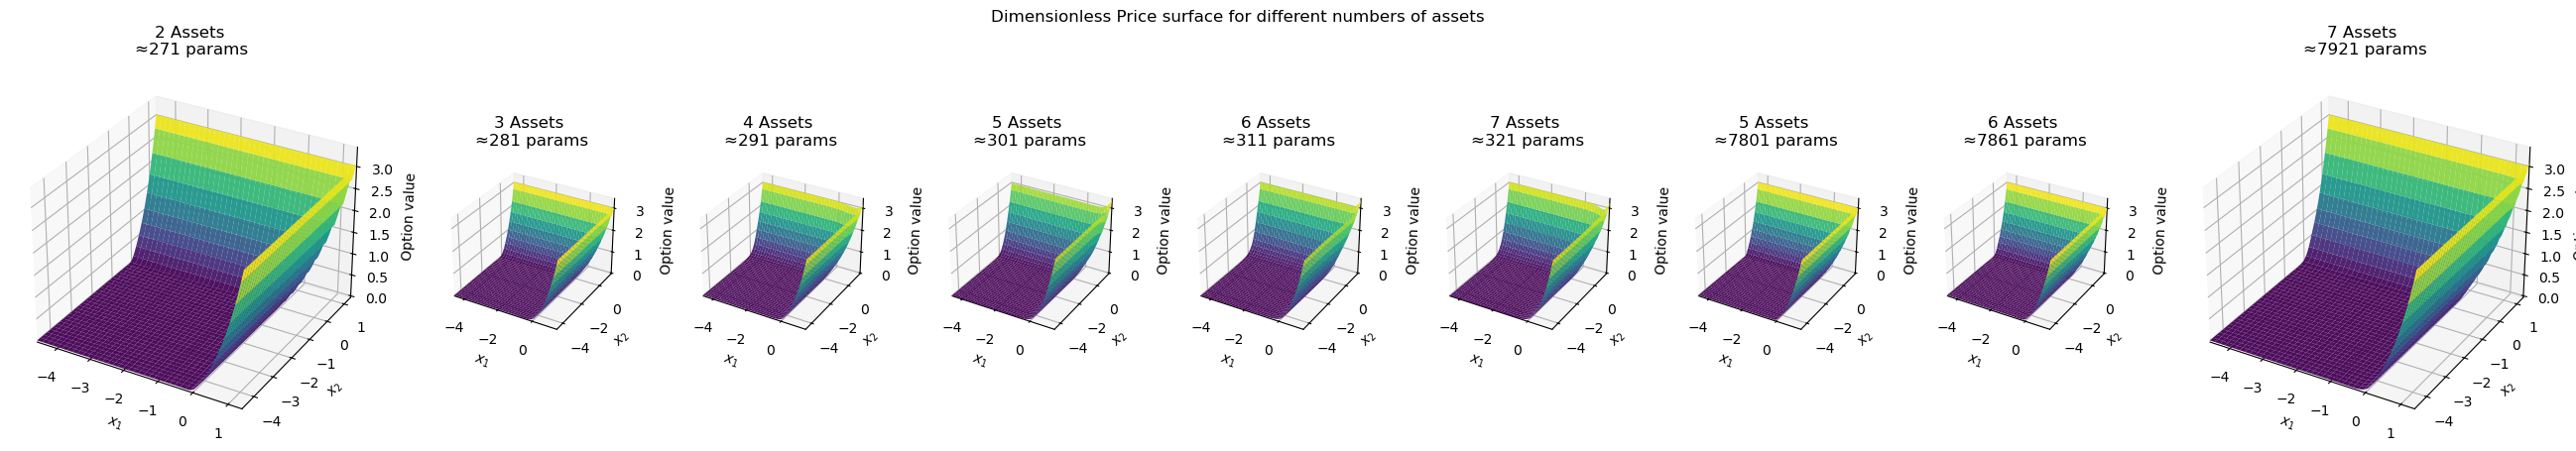

In [6]:
n = 2
params = OptionParameters(
                n_assets=n,
                tau=1.0,
                sigma=np.array([0.2] * n),
                rho=np.eye(n) + 0.25 * (np.ones((n, n)) - np.eye(n)),
                r=0.05,
                strike=100,
                payoff=payoff
            )

def model_param_count(model):
    return sum(p.numel() for p in model.parameters())

def plot_surfaces_dimless(bench,
                  x_min, x_max,
                  strike=100.,
                  pts=60,
                  fixed=None):
    """
    Visualise every trained network as S1-S2→V surfaces.
    Layout:  big (smallest assets) • several small • big (largest assets).
    """
    fixed = 1.0 if fixed is None else fixed

    # ------------------------------------------------------------------ #
    # 1) gather nets and sort by param-count (ascending)                  #
    # ------------------------------------------------------------------ #
    key_model_pairs = []
    for key in bench:
        _, nn_shape, assets = key.split('_')
        assets = int(assets)
        print(f"Loading {key}: {assets} assets, shape {nn_shape}")
        if nn_shape == "10x3":
            model = MLP(in_dim=assets+1, hidden_layers=[10, 10, 10], out_dim=1).to(DEV)
        else:
            model = MLP(in_dim=assets+1, hidden_layers=[60, 60, 60], out_dim=1).to(DEV)
        model.load_state_dict(torch.load(f"{key}.pt", map_location='cpu'))
        model.eval()
        key_model_pairs.append((key, model, assets, model_param_count(model)))

    key_model_pairs.sort(key=lambda x: x[3])                  # ascending
    n_models = len(key_model_pairs)

    # ------------------------------------------------------------------ #
    # 2) figure layout: first & last get 3× the width of inner ones      #
    # ------------------------------------------------------------------ #
    if n_models == 1:
        wr = [1]
    elif n_models == 2:
        wr = [1, 1]
    else:
        wr = [2] + [1]*(n_models-2) + [2]

    fig = plt.figure(figsize=(3*sum(wr), 5))
    gs  = fig.add_gridspec(1, n_models, width_ratios=wr, wspace=0.30)
    fig.subplots_adjust(right=0.90) 
    # ------------------------------------------------------------------ #
    # 3) prepare evaluation grid (log-space x1,x2 then exp→price)        #
    # ------------------------------------------------------------------ #
    x1 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x2 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x1g, x2g = torch.meshgrid(x1, x2, indexing='ij')

    def make_input_grid(n_assets):
        pad = torch.full((pts*pts, n_assets-2), (x_min+x_max)/2, dtype=DTYPE)
        tau = torch.zeros((pts*pts, 1), dtype=DTYPE)
        return torch.cat([x1g.reshape(-1,1), x2g.reshape(-1,1), pad, tau], dim=1)

    # ------------------------------------------------------------------ #
    # 4) evaluate all models once to fix a common z-range                #
    # ------------------------------------------------------------------ #
    V_surfaces = []
    zmin, zmax = +float('inf'), -float('inf')
    for _, m, assets, _ in key_model_pairs:
        with torch.no_grad():
            V = m(make_input_grid(assets)).cpu().numpy().reshape(pts, pts)
        V_surfaces.append(V)
        zmin, zmax = min(zmin, V.min()), max(zmax, V.max())

    # ------------------------------------------------------------------ #
    # 5) plot                                                           #
    # ------------------------------------------------------------------ #
    for col, ((key, _, assets, n_pars), V) in enumerate(zip(key_model_pairs, V_surfaces)):
        ax = fig.add_subplot(gs[0, col], projection='3d')

        # Slightly lower elevation for inner (small) panels
        # elev = 30 if col in (0, n_models-1) else 15
        elev = 30
        ax.view_init(elev, -60)

        ax.plot_surface(x1g.numpy(), x2g.numpy(), V,
                        antialiased=True, cmap='viridis',
                        rcount=pts//2, ccount=pts//2, alpha=0.95)

        ax.set_title(f"{assets} Assets \n≈{n_pars} params", pad=10)
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_zlabel('Option value')
        # if col == 0:
        # else:
        #     ax.set_zticks([])

        ax.set_zlim(zmin, zmax)                      # common scale
        ax.set_xlim(x1g.min(), x1g.max())
        ax.set_ylim(x2g.min(), x2g.max())

    fig.suptitle("Dimensionless Price surface for different numbers of assets")
    plt.savefig("dimless_price_surfaces.png", dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------------------------------------------------------------
# call it
plot_surfaces_dimless(bench, x_min=params.x_min, x_max=np.log(4),
              strike=params.strike,  # 100 in your training block
              pts=80, fixed=1.0)  # fixed=1.0 means

Loading model_10x3_2: 2 assets, shape 10x3
Loading model_10x3_3: 3 assets, shape 10x3
Loading model_10x3_4: 4 assets, shape 10x3
Loading model_10x3_5: 5 assets, shape 10x3
Loading model_10x3_6: 6 assets, shape 10x3
Loading model_10x3_7: 7 assets, shape 10x3
Loading model_60x3_5: 5 assets, shape 60x3
Loading model_60x3_6: 6 assets, shape 60x3
Loading model_60x3_7: 7 assets, shape 60x3


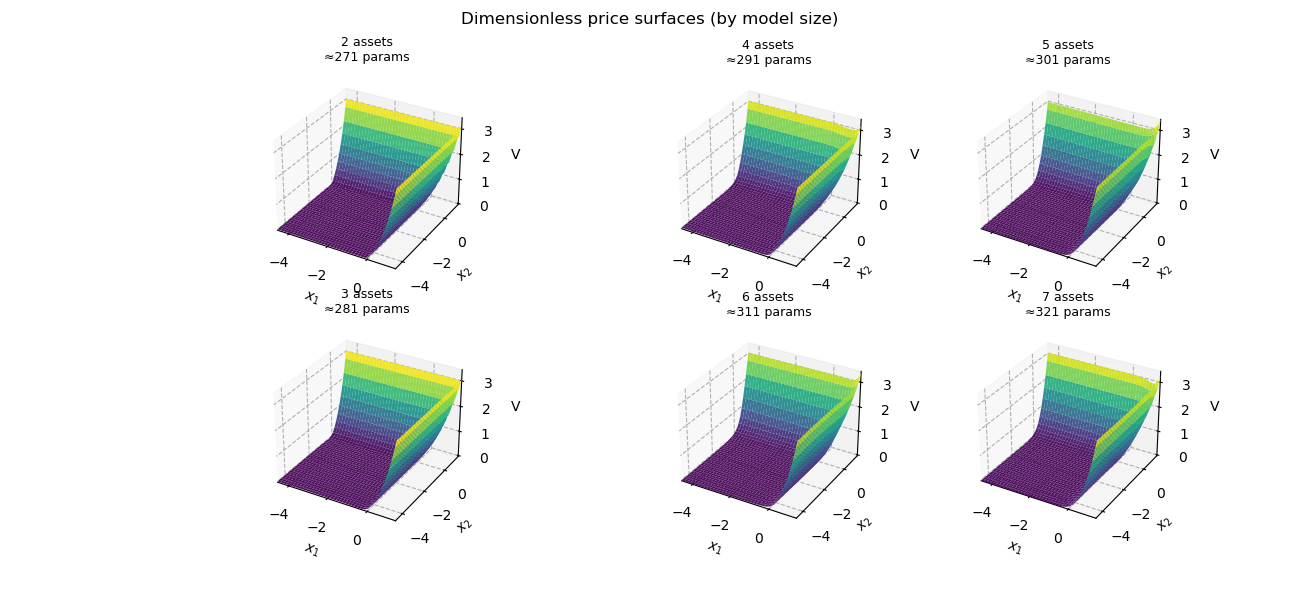

In [32]:
def plot_surfaces_dimless(
        bench, *, x_min, x_max,
        strike=100., pts=60, fixed=1.0):

    # ------------------------------------------------------------------ #
    # 1) gather & sort nets                                               #
    # ------------------------------------------------------------------ #
    def n_pars(model):
        return sum(p.numel() for p in model.parameters())

    triples = []
    for key in bench:
        _, nn_shape, assets = key.split('_')
        assets = int(assets)
        print(f"Loading {key}: {assets} assets, shape {nn_shape}")
        if nn_shape == "10x3":
            model = MLP(in_dim=assets+1, hidden_layers=[10, 10, 10], out_dim=1).to(DEV)
        else:
            model = MLP(in_dim=assets+1, hidden_layers=[60, 60, 60], out_dim=1).to(DEV)
        model.load_state_dict(torch.load(f"{key}.pt", map_location='cpu'))
        model.eval()
        triples.append((key, model, assets, model_param_count(model)))

    triples.sort(key=lambda t: t[3])          # ascending by #params
    if len(triples) < 2:
        raise ValueError("Need at least two models for this layout")

    bigA, bigB, *middle = triples            # first two are 'big'
    middle = middle[:4]                      # keep at most 4

    # ------------------------------------------------------------------ #
    # 2) evaluation grid                                                  #
    # ------------------------------------------------------------------ #
    x1 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x2 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x1g, x2g = torch.meshgrid(x1, x2, indexing='ij')

    def make_input(n_assets):
        pad = torch.full((pts*pts, n_assets-2), (x_min+x_max)/2, dtype=DTYPE)
        tau = torch.zeros((pts*pts,1), dtype=DTYPE)
        return torch.cat([x1g.reshape(-1,1), x2g.reshape(-1,1), pad, tau], 1)

    # ------------------------------------------------------------------ #
    # 3) evaluate once, unify z-range                                     #
    # ------------------------------------------------------------------ #
    Vdict, zmin, zmax = {}, +np.inf, -np.inf
    for key, model, n_assets, _ in [bigA, bigB] + middle:
        with torch.no_grad():
            V = model(make_input(n_assets)).cpu().numpy().reshape(pts, pts)
        Vdict[key] = (V, n_assets)
        zmin, zmax = min(zmin, V.min()), max(zmax, V.max())

    # ------------------------------------------------------------------ #
    # 4) layout: 2 rows × 3 cols, left col twice as wide                 #
    # ------------------------------------------------------------------ #
    fig = plt.figure(figsize=(13, 6))
    gs  = fig.add_gridspec(2, 3, width_ratios=[2,1,1], wspace=0.35)

    slots = [
        (gs[0, 0], bigA),
        (gs[1, 0], bigB),
        (gs[0, 1], middle[0] if len(middle)>0 else None),
        (gs[0, 2], middle[1] if len(middle)>1 else None),
        (gs[1, 1], middle[2] if len(middle)>2 else None),
        (gs[1, 2], middle[3] if len(middle)>3 else None),
    ]

    for cell, item in slots:
        if item is None:
            continue
        key, _, n_assets, npars = item
        V, _ = Vdict[key]

        ax = fig.add_subplot(cell, projection='3d')
        ax.view_init(30, -60)
        ax.plot_surface(x1g.numpy(), x2g.numpy(), V,
                        cmap='viridis', alpha=0.94,
                        rcount=pts//2, ccount=pts//2)
        ax.set_xlim(x1g.min(), x1g.max())
        ax.set_ylim(x2g.min(), x2g.max())
        ax.set_zlim(zmin, zmax)
        ax.set_xlabel(r'$x_1$')
        ax.set_ylabel(r'$x_2$')
        ax.set_zlabel('V')
        ax.set_title(f"{n_assets} assets\n≈{npars} params", fontsize=9, pad=8)

    fig.suptitle("Dimensionless price surfaces (by model size)", fontsize=12)
    plt.show()


plot_surfaces_dimless(
    bench, x_min=params.x_min, x_max=np.log(4),
    strike=params.strike, pts=80)


Loading model_10x3_2: 2 assets, shape 10x3
Loading model_10x3_3: 3 assets, shape 10x3
Loading model_10x3_4: 4 assets, shape 10x3
Loading model_10x3_5: 5 assets, shape 10x3
Loading model_10x3_6: 6 assets, shape 10x3
Loading model_10x3_7: 7 assets, shape 10x3
Loading model_60x3_5: 5 assets, shape 60x3
Loading model_60x3_6: 6 assets, shape 60x3
Loading model_60x3_7: 7 assets, shape 60x3


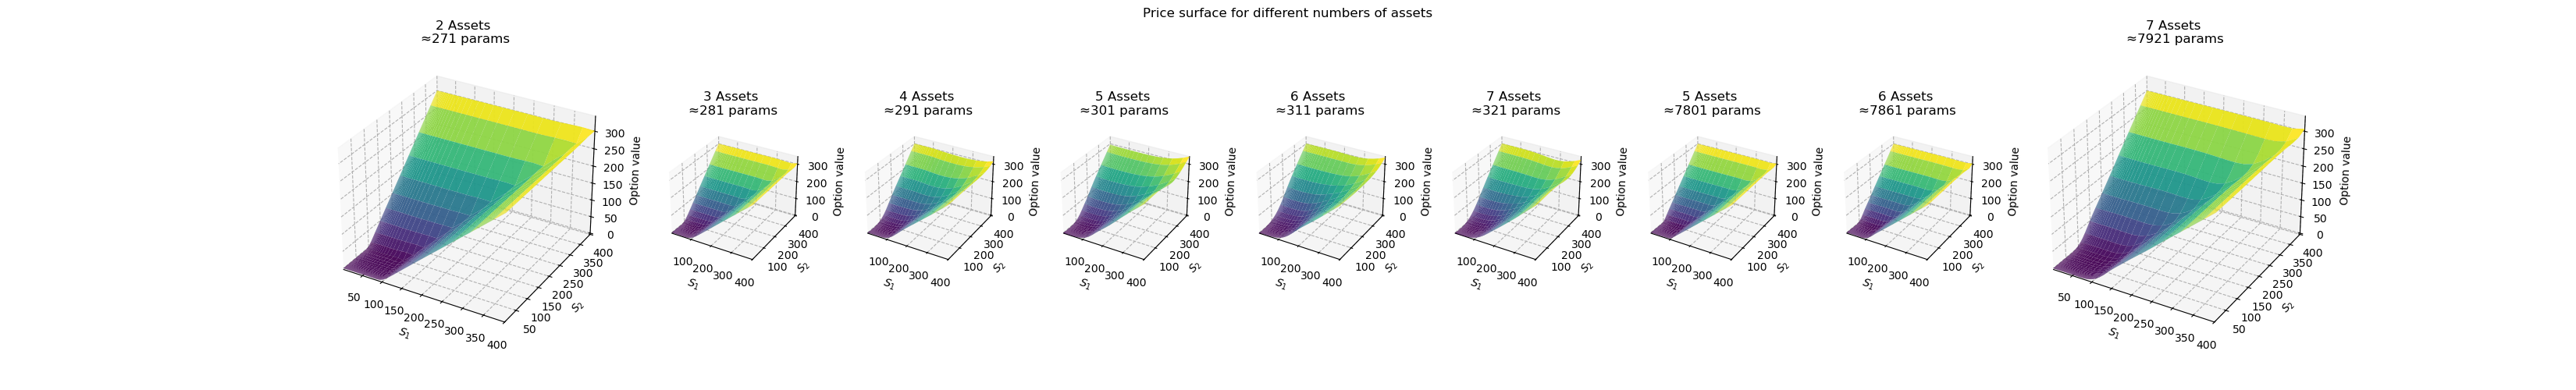

In [33]:
def model_param_count(model):
    return sum(p.numel() for p in model.parameters())

def plot_surfaces(bench,
                  x_min, x_max,
                  strike=100.,
                  pts=60,
                  fixed=None):
    """
    Visualise every trained network as S1-S2→V surfaces.
    Layout:  big (smallest assets) • several small • big (largest assets).
    """
    fixed = 1.0 if fixed is None else fixed

    # ------------------------------------------------------------------ #
    # 1) gather nets and sort by param-count (ascending)                  #
    # ------------------------------------------------------------------ #
    key_model_pairs = []
    for key in bench:
        _, nn_shape, assets = key.split('_')
        assets = int(assets)
        print(f"Loading {key}: {assets} assets, shape {nn_shape}")
        if nn_shape == "10x3":
            model = MLP(in_dim=assets+1, hidden_layers=[10, 10, 10], out_dim=1).to(DEV)
        else:
            model = MLP(in_dim=assets+1, hidden_layers=[60, 60, 60], out_dim=1).to(DEV)
        model.load_state_dict(torch.load(f"{key}.pt", map_location='cpu'))
        model.eval()
        key_model_pairs.append((key, model, assets, model_param_count(model)))


    key_model_pairs.sort(key=lambda x: x[3])                  # ascending
    n_models = len(key_model_pairs)

    # ------------------------------------------------------------------ #
    # 2) figure layout: first & last get 3× the width of inner ones      #
    # ------------------------------------------------------------------ #
    if n_models == 1:
        wr = [2]
    elif n_models == 2:
        wr = [2, 2]
    else:
        wr = [2] + [1]*(n_models-2) + [2]

    fig = plt.figure(figsize=(3*sum(wr), 5))
    gs  = fig.add_gridspec(1, n_models, width_ratios=wr, wspace=0.30)
    fig.subplots_adjust(right=0.90) 
    # ------------------------------------------------------------------ #
    # 3) prepare evaluation grid (log-space x1,x2 then exp→price)        #
    # ------------------------------------------------------------------ #
    x1 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x2 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x1g, x2g = torch.meshgrid(x1, x2, indexing='ij')
    S1g, S2g = x1g.exp()*strike, x2g.exp()*strike

    def make_input_grid(n_assets):
        pad = torch.full((pts*pts, n_assets-2), (x_min+x_max)/2, dtype=DTYPE)
        tau = torch.zeros((pts*pts, 1), dtype=DTYPE)
        return torch.cat([x1g.reshape(-1,1), x2g.reshape(-1,1), pad, tau], dim=1)

    # ------------------------------------------------------------------ #
    # 4) evaluate all models once to fix a common z-range                #
    # ------------------------------------------------------------------ #
    V_surfaces = []
    zmin, zmax = +float('inf'), -float('inf')
    for _, m, assets, _ in key_model_pairs:
        with torch.no_grad():
            V = m(make_input_grid(assets)).cpu().numpy().reshape(pts, pts) * strike
        V_surfaces.append(V)
        zmin, zmax = min(zmin, V.min()), max(zmax, V.max())

    # ------------------------------------------------------------------ #
    # 5) plot                                                           #
    # ------------------------------------------------------------------ #
    for col, ((key, _, assets, n_pars), V) in enumerate(zip(key_model_pairs, V_surfaces)):
        ax = fig.add_subplot(gs[0, col], projection='3d')

        # Slightly lower elevation for inner (small) panels
        # elev = 30 if col in (0, n_models-1) else 15
        elev = 30
        ax.view_init(elev, -60)

        ax.plot_surface(S1g.numpy(), S2g.numpy(), V,
                        antialiased=True, cmap='viridis',
                        rcount=pts//2, ccount=pts//2, alpha=0.95)

        ax.set_title(f"{assets} Assets \n≈{n_pars} params", pad=10)
        ax.set_xlabel('$S_1$')
        ax.set_ylabel('$S_2$')
        ax.set_zlabel('Option value')
        # if col == 0:
        # else:
        #     ax.set_zticks([])

        ax.set_zlim(zmin, zmax)                      # common scale
        ax.set_xlim(S1g.min(), S1g.max())
        ax.set_ylim(S2g.min(), S2g.max())

    fig.suptitle("Price surface for different numbers of assets")
    plt.show()

# -------------------------------------------------------------------------------
# call it
plot_surfaces(bench, x_min=params.x_min, x_max=np.log(4),
              strike=params.strike,  # 100 in your training block
              pts=80, fixed=1.0)  # fixed=1.0 means


/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_52393/477774803.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


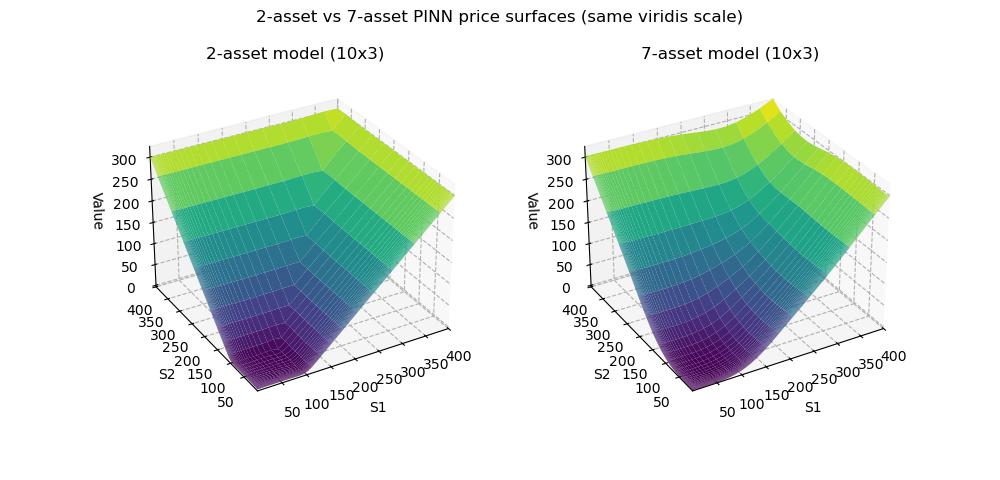

In [34]:
# %% [markdown]
# === side-by-side surfaces — both full-strength viridis ====================
# %%
import torch, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401

def _rebuild(arch: str, d: int):
    w, depth = map(int, arch.split("x"))
    return MLP(in_dim=d+1, hidden_layers=[w]*depth, out_dim=1).to(DEV, DTYPE)

def plot_two_panels_same_cmap(
        bench, *, x_min, x_max, strike=100., pts=60):
    # ── pick smallest-d and largest-d checkpoints -----------------------
    counts = [int(k.split('_')[-1]) for k in bench]
    d_small, d_big = min(counts), max(counts)
    k_small = next(k for k in bench if k.endswith(f"_{d_small}"))
    k_big   = next(k for k in bench if k.endswith(f"_{d_big}"))
    arch_s  = k_small.split('_')[1]
    arch_b  = k_big.split('_')[1]

    net_s = _rebuild(arch_s, d_small); net_s.load_state_dict(torch.load(f"{k_small}.pt", map_location=DEV)); net_s.eval()
    net_b = _rebuild(arch_b, d_big);   net_b.load_state_dict(torch.load(f"{k_big}.pt",   map_location=DEV)); net_b.eval()

    # grid
    x1 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x2 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x1g, x2g = torch.meshgrid(x1, x2, indexing='ij')
    S1g, S2g = torch.exp(x1g) * strike, torch.exp(x2g) * strike
    def _inp(d):
        pad  = torch.full((pts*pts, d-2), (x_min+x_max)/2, dtype=DTYPE)
        tau0 = torch.zeros((pts*pts,1), dtype=DTYPE)
        return torch.cat([x1g.reshape(-1,1), x2g.reshape(-1,1), pad, tau0], 1)

    with torch.no_grad():
        V_s = (net_s(_inp(d_small))*strike).cpu().numpy().reshape(pts,pts)
        V_b = (net_b(_inp(d_big  ))*strike).cpu().numpy().reshape(pts,pts)

    zlo, zhi = min(V_s.min(), V_b.min()), max(V_s.max(), V_b.max())

    fig = plt.figure(figsize=(10,4.8)); gs = fig.add_gridspec(1,2,wspace=.28)

    for ax, V, d, arch in [
            (fig.add_subplot(gs[0,0], projection='3d'), V_s, d_small, arch_s),
            (fig.add_subplot(gs[0,1], projection='3d'), V_b, d_big,   arch_b)]:

        # SAME colormap, SAME normalization
        norm = plt.Normalize(zlo, zhi)
        ax.plot_surface(S1g.numpy(), S2g.numpy(), V,
                        cmap='viridis', norm=norm,
                       
                        linewidth=0, antialiased=True, alpha=1.0)

        ax.set_xlim(S1g.min(), S1g.max()); ax.set_ylim(S2g.min(), S2g.max())
        ax.set_zlim(zlo, zhi); ax.view_init(30,-120)
        ax.set_xlabel('S1'); ax.set_ylabel('S2'); ax.set_zlabel('Value')
        ax.set_title(f"{d}-asset model ({arch})", pad=10)

    fig.suptitle("2-asset vs 7-asset PINN price surfaces (same viridis scale)",
                 fontsize=12)
    plt.tight_layout(); plt.show()

# -------------------------------------------------------------------------
plot_two_panels_same_cmap(
    bench,
    x_min=params.x_min,
    x_max=np.log(4),
    strike=params.strike,
    pts=80,
)


/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_52393/3473358571.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(4*n, 4.5))
/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_52393/3473358571.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


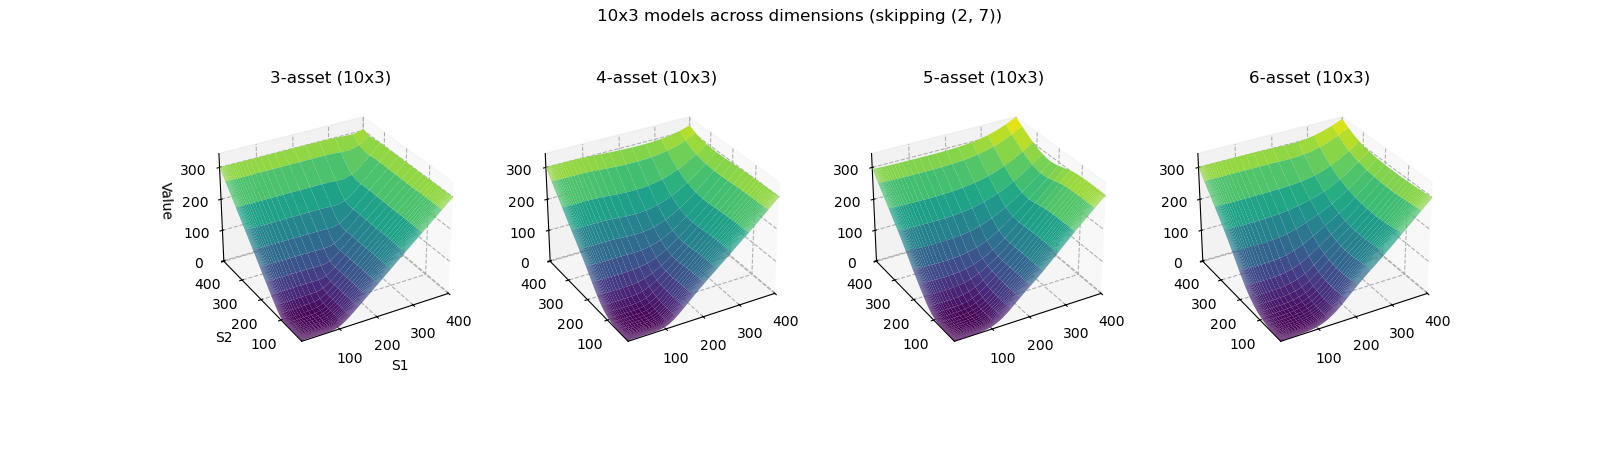

In [35]:
# %% [markdown]
# === row of 10×3 models (skip 2- and 7-asset) ==========================
# %%
def plot_row_arch(bench, arch, *, x_min, x_max,
                  strike=100., pts=60, skip_dims=(2, 7)):
    """
    Plot price surfaces for every checkpoint whose architecture matches `arch`,
    but ignore any whose dimension is in `skip_dims` (defaults to 2 and 7).
    """
    # 1️⃣  pick models with matching arch and allowed dimension
    models = sorted(
        [k for k in bench
         if k.split('_')[1] == arch and int(k.split('_')[-1]) not in skip_dims],
        key=lambda k: int(k.split('_')[-1])
    )
    ds = [int(k.split('_')[-1]) for k in models]
    if not models:
        raise ValueError(f"No {arch} checkpoints left after skipping {skip_dims}")

    # 2️⃣  common grid (same as before)
    x1 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x2 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x1g, x2g = torch.meshgrid(x1, x2, indexing='ij')
    S1g, S2g = torch.exp(x1g) * strike, torch.exp(x2g) * strike

    Vs, zlo, zhi = [],  np.inf, -np.inf
    for k, d in zip(models, ds):
        net = _rebuild(arch, d)
        net.load_state_dict(torch.load(f"{k}.pt", map_location=DEV))
        net.eval()
        with torch.no_grad():
            V = (
                net(torch.cat([
                    x1g.reshape(-1, 1),
                    x2g.reshape(-1, 1),
                    torch.full((pts*pts, d-2), (x_min+x_max)/2, dtype=DTYPE),
                    torch.zeros((pts*pts, 1), dtype=DTYPE)
                ], 1)) * strike
            ).cpu().numpy().reshape(pts, pts)
        Vs.append(V); zlo, zhi = min(zlo, V.min()), max(zhi, V.max())

    # 3️⃣  plot row
    n = len(models)
    fig = plt.figure(figsize=(4*n, 4.5))
    gs  = fig.add_gridspec(1, n, wspace=.25)
    norm = plt.Normalize(zlo, zhi)

    for i, (V, d) in enumerate(zip(Vs, ds)):
        ax = fig.add_subplot(gs[0, i], projection='3d')
        ax.plot_surface(S1g.numpy(), S2g.numpy(), V,
                        cmap='viridis', norm=norm,
                        linewidth=0, antialiased=True)
        ax.set_xlim(S1g.min(), S1g.max()); ax.set_ylim(S2g.min(), S2g.max())
        ax.set_zlim(zlo, zhi);            ax.view_init(30, -120)
        ax.set_title(f"{d}-asset ({arch})", pad=10)
        if i == 0:
            ax.set_xlabel('S1'); ax.set_ylabel('S2'); ax.set_zlabel('Value')

    fig.suptitle(f"{arch} models across dimensions (skipping {skip_dims})",
                 fontsize=12)
    plt.tight_layout(); plt.show()

# -------------------------------------------------------------------------
plot_row_arch(
    bench,
    arch="10x3",
    x_min=params.x_min,
    x_max=np.log(4),
    strike=params.strike,
    pts=80,
    skip_dims=(2, 7)
)

/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_52393/3975574340.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


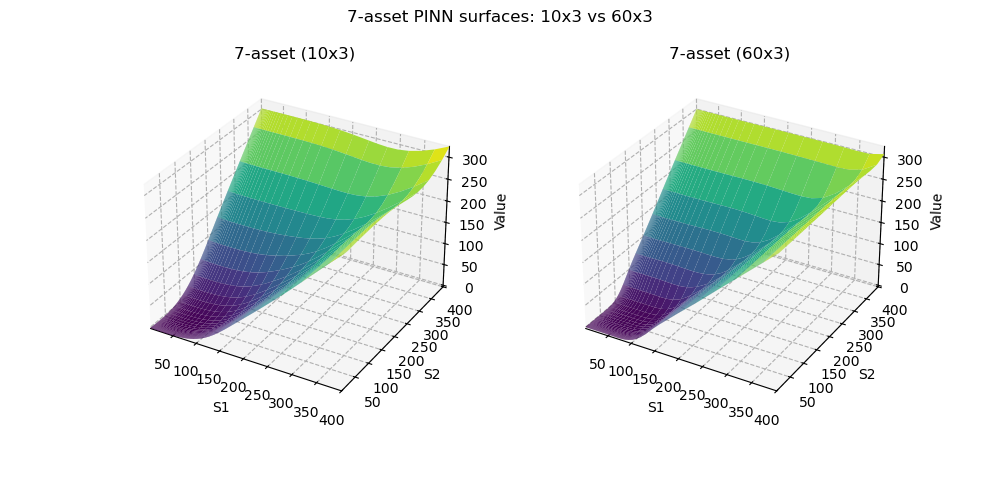

In [48]:
# %% [markdown]
# === 7-asset: 10×3 vs 60×3 =============================================
# %%
def plot_same_d_two_arch(
        bench, d, arch1, arch2, *, x_min, x_max, strike=100., pts=80):
    """
    Compare two different architectures side-by-side for the *same* dimension d.
    """
    k1 = next(k for k in bench if k.split('_')[1] == arch1 and k.endswith(f"_{d}"))
    k2 = next(k for k in bench if k.split('_')[1] == arch2 and k.endswith(f"_{d}"))

    net1 = _rebuild(arch1, d); net1.load_state_dict(torch.load(f"{k1}.pt", map_location=DEV)); net1.eval()
    net2 = _rebuild(arch2, d); net2.load_state_dict(torch.load(f"{k2}.pt", map_location=DEV)); net2.eval()

    x1 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x2 = torch.linspace(x_min, x_max, pts, dtype=DTYPE)
    x1g, x2g = torch.meshgrid(x1, x2, indexing='ij')
    S1g, S2g = torch.exp(x1g) * strike, torch.exp(x2g) * strike
    pad  = torch.full((pts*pts, d-2), (x_min+x_max)/2, dtype=DTYPE)
    tau0 = torch.zeros((pts*pts, 1), dtype=DTYPE)
    inp  = torch.cat([x1g.reshape(-1,1), x2g.reshape(-1,1), pad, tau0], 1)

    with torch.no_grad():
        V1 = (net1(inp)*strike).cpu().numpy().reshape(pts,pts)
        V2 = (net2(inp)*strike).cpu().numpy().reshape(pts,pts)
    zlo, zhi = min(V1.min(), V2.min()), max(V1.max(), V2.max())

    fig = plt.figure(figsize=(10, 4.8)); gs = fig.add_gridspec(1, 2, wspace=.28)
    for ax, V, arch in [
            (fig.add_subplot(gs[0,0], projection='3d'), V1, arch1),
            (fig.add_subplot(gs[0,1], projection='3d'), V2, arch2)]:
        ax.plot_surface(S1g.numpy(), S2g.numpy(), V,
                        cmap='viridis', norm=plt.Normalize(zlo, zhi),
                        linewidth=0, antialiased=True)
        ax.set_xlim(S1g.min(), S1g.max()); ax.set_ylim(S2g.min(), S2g.max())
        ax.set_zlim(zlo, zhi); ax.view_init(30, -60)
        ax.set_xlabel('S1');  ax.set_ylabel('S2'); ax.set_zlabel('Value')
        ax.set_title(f"7-asset ({arch})", pad=10)

    fig.suptitle("7-asset PINN surfaces: 10x3 vs 60x3",
                 fontsize=12)
    plt.tight_layout(); plt.show()

# -------------------------------------------------------------------------
plot_same_d_two_arch(
    bench,
    d=7,
    arch1="10x3",
    arch2="60x3",
    x_min=params.x_min,
    x_max=np.log(4),
    strike=params.strike,
    pts=80,
)



In [37]:

# load json if it exists, else create it
try:
    with open("bench.json", "r") as f:
        bench = json.load(f)
except FileNotFoundError:
    bench = {}
    with open("bench.json", "w") as f:
        json.dump(bench, f)
        
@njit(parallel=True, fastmath=True)
def _mc_prices_numba(s0, drift, vol_sqrt, Zcorr, strike, df, put_flag):
    n_prices, n_sims, n_assets = Zcorr.shape
    out = np.empty(n_prices, dtype=np.float64)

    for i in prange(n_prices):                       # parallel over price points
        payoff_sum = 0.0
        for j in range(n_sims):
            payoff_tmp = 0.0 if put_flag else -strike  # running max / min
            for k in range(n_assets):
                st = s0[i, k] * math.exp(drift[k] + vol_sqrt[k] * Zcorr[i, j, k])
                if put_flag:
                    # put on MIN ­­­→ want min(ST)
                    if k == 0 or st < payoff_tmp:
                        payoff_tmp = st
                else:
                    # call on MAX ­→ want max(ST)
                    if st > payoff_tmp:
                        payoff_tmp = st
            payoff = max(strike - payoff_tmp, 0.0) if put_flag else max(payoff_tmp - strike, 0.0)
            payoff_sum += payoff
        out[i] = df * payoff_sum / n_sims
    return out


def compare_with_mc(
    model,
    params,
    n_prices: int,
    n_simulations: int,
    *,
    seed=None,
    split_output=False,
    opt_type: str = "call",
):
    from scipy.stats import norm as _spnorm
    rng = np.random.default_rng(seed)

    # Scalars & vectors --------------------------------------------------------
    r, tau, strike = params.r, params.tau, params.strike
    n_assets = params.n_assets
    sigma = np.asarray(params.sigma, dtype=np.float64)
    rho   = np.asarray(params.rho,   dtype=np.float64)

    # 1. Generate uniform log-spots on [x_min, x_max] --------------------------
    x0 = rng.uniform(params.x_min, params.x_max, size=(n_prices, n_assets))
    s0 = np.exp(x0) * strike

    # 2. Cholesky of correlation ----------------------------------------------
    L = np.linalg.cholesky(rho).astype(np.float64)

    # 3. Pre-compute drift & σ√τ ----------------------------------------------
    drift     = (r - 0.5 * sigma ** 2) * tau          # shape (n_assets,)
    vol_sqrt  = sigma * math.sqrt(tau)                # shape (n_assets,)
    discount  = math.exp(-r * tau)                    # scalar

    # 4. NN prices (unchanged, but we feed it NumPy) ---------------------------
    t0 = time.perf_counter()
    inp_np = np.concatenate([x0, np.full((n_prices, 1), tau)], axis=1)
    with torch.no_grad():
        inp_torch = torch.as_tensor(inp_np, dtype=DTYPE, device=DEV)
        y = model(inp_torch)
        if split_output:
            y = y.split(1, dim=1)[0]
        nn_prices = (y.squeeze() * strike).cpu().numpy()
    nn_time = time.perf_counter() - t0

    # 5. Quasi-random normals (Sobol → Φ-1) ------------------------------------
    # Sobol length must be a power-of-two:  2^m ≥ n_prices*n_simulations
    n_total = n_prices * n_simulations
    m = int(math.ceil(math.log2(n_total)))
    sobol_engine = qmc.Sobol(d=n_assets, scramble=True, seed=seed)
    U = sobol_engine.random_base2(m)[:n_total]        # (n_total, n_assets)
    Z = _spnorm.ppf(U, loc=0.0, scale=1.0).astype(np.float64)
    Z = Z.reshape(n_prices, n_simulations, n_assets)  # (prices, sims, assets)

    # 6. Apply correlation  (NumPy BLAS) ---------------------------------------
    Zcorr = Z @ L.T                                   # (n_prices, n_sims, n_assets)

    # 7. Monte-Carlo valuation  (Numba) ----------------------------------------
    t0 = time.perf_counter()
    put_flag = 1 if opt_type.lower() == "put" else 0
    mc_prices = _mc_prices_numba(s0, drift, vol_sqrt, Zcorr,
                                 strike, discount, put_flag)
    mc_time = time.perf_counter() - t0

    # 8. Diagnostics -----------------------------------------------------------
    abs_err = np.abs(mc_prices - nn_prices)
    results = dict(
        nn_prices      = nn_prices,
        mc_prices      = mc_prices,
        abs_error      = abs_err,
        avg_error      = abs_err.mean(),
        max_error      = abs_err.max(),
        avg_mc_price   = mc_prices.mean(),
        avg_nn_price   = nn_prices.mean(),
        total_mc_time  = mc_time,
        total_nn_time  = nn_time,
        l2_rel_error   = np.linalg.norm(mc_prices - nn_prices)
                         / np.linalg.norm(mc_prices),
        avg_mc_time    = mc_time / n_prices,
        avg_nn_time    = nn_time / n_prices,
    )
    return results

def benchmark_compare_with_mc(
    model,
    params,
    *,
    n_prices: int,
    n_simulations: int,
    n_runs: int = 20,
    warmup: int = 1,
    seed: int | None = None,
    split_output: bool = False,
    opt_type: str = "call",
):
  
    rng = np.random.default_rng(seed)

    # -------------------- warm-up (compiles Numba once) ---------------------
    for _ in range(warmup):
        compare_with_mc(
            model, params, n_prices, n_simulations,
            seed=rng.integers(0, 2**32 - 1),
            split_output=split_output, opt_type=opt_type,
        )

    # -------------------- timed runs ---------------------------------------
    mc_times   = np.empty(n_runs)
    nn_times   = np.empty(n_runs)
    total_time = np.empty(n_runs)

    for i in range(n_runs):
        res = compare_with_mc(
            model, params, n_prices, n_simulations,
            seed=rng.integers(0, 2**32 - 1),
            split_output=split_output, opt_type=opt_type,
        )
        mc_times[i]   = res["total_mc_time"]
        nn_times[i]   = res["total_nn_time"]
        total_time[i] = mc_times[i] + nn_times[i]

    # -------------------- statistics ---------------------------------------
    def _fmt(x: np.ndarray, name: str):
        return (
            f"{name:9s}: mean = {x.mean()*1e3:7.2f} ms   "
            f"std = {x.std()*1e3:6.2f} ms   "
            f"range = [{x.min()*1e3:7.2f} … {x.max()*1e3:7.2f}] ms"
        )

    summary = "\n".join([
        _fmt(mc_times,   "MC"),
        _fmt(nn_times,   "NN"),
        _fmt(total_time, "Total"),
    ])

    return dict(mc=mc_times, nn=nn_times, total=total_time, summary=summary)



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


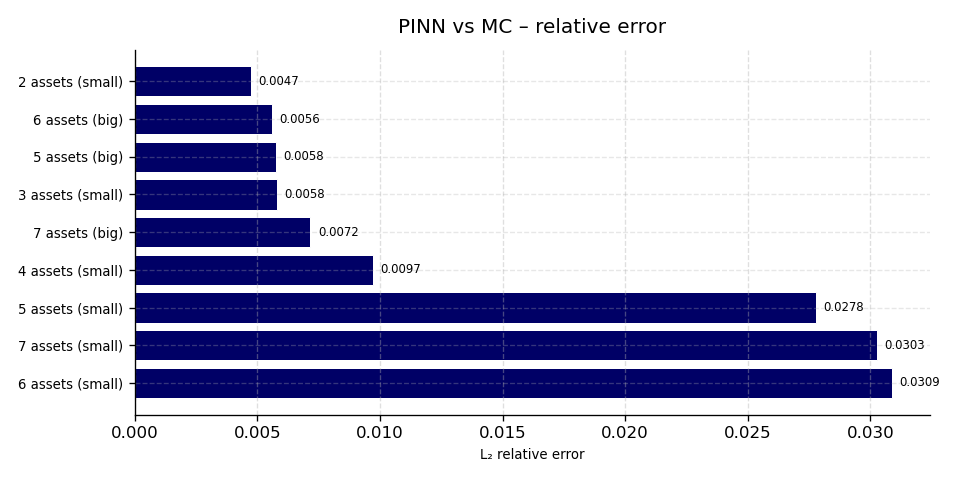

In [38]:
# ==============================================================
#  constants & styling
# ==============================================================
N_PRICES       = 200
N_SIMULATIONS  = 10_000
BAR_COLOUR     = "#000066"         # UC3M blue
FONTSIZE_LAB   = 8
FONTSIZE_ANN   = 7

# ==============================================================
#  helper: parse "64x4" -> [64, 64, 64, 64]
# ==============================================================
def parse_shape(shape: str) -> list[int]:
    """Return list[int] representing hidden-layer sizes.
       Accepts e.g. '10x2' (width × depth) or '128-64-32'."""
    if "x" in shape:                       # width x depth
        width, depth = map(int, shape.lower().split("x"))
        return [width] * depth
    return list(map(int, shape.replace(" ", "").split("-")))

# ==============================================================
#  1) build OptionParameters per asset dimension (once)
# ==============================================================
asset_to_params = {
    n: OptionParameters(
        n_assets=n,
        tau=1.0,
        sigma=np.full(n, 0.20),
        rho=np.eye(n) + 0.25 * (np.ones((n, n)) - np.eye(n)),
        r=0.05,
        strike=100,
        payoff=payoff,
    )
    for n in {int(k.split("_")[-1]) for k in bench}            # unique counts
}

# ==============================================================
#  2) loop over benchmarks, evaluate & store errors/timing
# ==============================================================
eval_times = {}
for key, entry in bench.items():

    # if "avg_abs_error" in entry:           # already processed
    #     continue

    n_assets = int(key.split("_")[-1])
    params   = asset_to_params[n_assets]

    # --- rebuild model exactly as trained --------------------------
    hidden_spec = parse_shape(key.split("_")[1])                # "10x2" → [10,10]:
    model = MLP(in_dim=n_assets + 1,
                hidden_layers=hidden_spec,
                out_dim=1).to(device=DEV, dtype=DTYPE)

    with torch.no_grad():
        model.load_state_dict(torch.load(f"{key}.pt", map_location=DEV))
        model.eval()

        # comparison
        cmp = compare_with_mc(
            model,
            params,
            n_prices=N_PRICES,
            n_simulations=N_SIMULATIONS,
            seed=42
        )

    entry["avg_abs_error"] = float(cmp["avg_error"])
    entry["l2_rel_error"]  = float(cmp["l2_rel_error"])
    eval_times[key] = {k: float(v) for k, v in cmp.items()
                       if "time" in k}

# ==============================================================
#  3) plotting – horizontal, sorted by relative error
# ==============================================================
labels   = list(bench.keys())
names    = [bench[k].get("name", k) for k in labels]
rel_err  = np.array([bench[k]["l2_rel_error"] for k in labels])

order    = np.argsort(rel_err)            # best (small) → worst (large)
rel_err  = rel_err[order]
names    = np.array(names)[order]

fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
bars = ax.barh(range(len(names)), rel_err, color=BAR_COLOUR,
               edgecolor="white", linewidth=.6)

# annotate each bar
for bar, err in zip(bars, rel_err):
    ax.text(err + max(rel_err)*0.01,                # a bit to the right
            bar.get_y() + bar.get_height()/2,
            f"{err:.4F}", va="center",
            fontsize=FONTSIZE_ANN)

ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=FONTSIZE_LAB)
ax.invert_yaxis()                                   # best on top
ax.set_xlabel("L\u2082 relative error", fontsize=FONTSIZE_LAB)
ax.set_title("PINN vs MC – relative error", pad=10)
ax.xaxis.grid(True, linestyle="--", alpha=.4, zorder=0)

for side in ("right", "top"):
    ax.spines[side].set_visible(False)

plt.tight_layout()
plt.show()


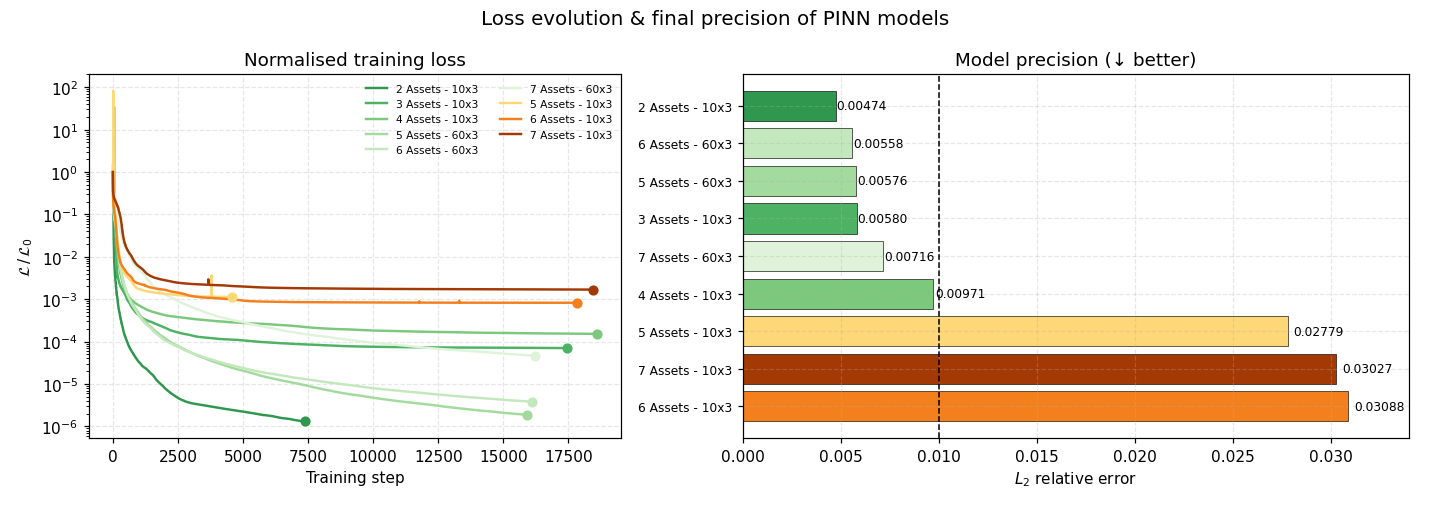

In [46]:
import matplotlib as mpl

# ───────────────────────────────── configuration ─────────────────────────
THRESH       = 1e-2                         # precision cut-off
GOOD_CMAP    = plt.cm.Greens_r              # dark→light greens
BAD_CMAP     = plt.cm.YlOrBr                # yellows / oranges
mpl.rcParams.update({
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": .3
})

# ───────────────────────── helpers ───────────────────────────────────────
def _parse_key(k: str):
    _, shape, n = k.split("_")
    return int(n), shape

def _nice_label(k: str) -> str:
    n, shape = _parse_key(k)
    return f"{n} Assets - {shape}"                 # “#assets – shape”


def _seq_colour(i, total, cmap, lo=0.30, hi=0.85):
    """Colour i of total spread evenly between *lo* and *hi* of the cmap."""
    if total <= 1:
        return cmap((lo + hi) / 2)
    return cmap(lo + (hi - lo) * i / (total - 1))

# ───────────────────────── split models by precision ─────────────────────
good_keys = [k for k in bench if bench[k]["l2_rel_error"] < THRESH]
bad_keys  = [k for k in bench if k not in good_keys]

colour_of = {}
for grp, cmap in [(sorted(good_keys), GOOD_CMAP),
                  (sorted(bad_keys),  BAD_CMAP)]:
    for i, k in enumerate(grp):
        colour_of[k] = _seq_colour(i, len(grp), cmap)

# ───────────────────────── figure layout ─────────────────────────────────
fig, (ax_loss, ax_prec) = plt.subplots(
    1, 2, figsize=(13, 4.6), dpi=110,
    gridspec_kw={"width_ratios": [2, 2.5]}
)

# ───────────────────────── LEFT: normalised loss ────────────────────────
for k in good_keys + bad_keys:              # deterministic order
    raw = np.asarray(bench[k]["losses"], dtype=float)
    if raw.size == 0:
        continue
    norm = raw / max(raw[0], 1e-12)
    ax_loss.plot(norm, lw=1.6, color=colour_of[k], label=_nice_label(k))
    # end-point marker (last non-NaN)
    last_idx = np.where(~np.isnan(norm))[0][-1]
    ax_loss.scatter(last_idx, norm[last_idx], s=32,
                    color=colour_of[k], zorder=3)

ax_loss.set_yscale("log")
ax_loss.set_xlabel("Training step")
ax_loss.set_ylabel(r"$\mathcal{L}\,/\,\mathcal{L}_0$")
ax_loss.set_title("Normalised training loss")
ax_loss.legend(fontsize=7, ncol=2, frameon=False)

# ───────────────────────── RIGHT: precision bars ────────────────────────
ordered_keys = sorted(bench, key=lambda k: bench[k]["l2_rel_error"])
prec_vals    = np.array([bench[k]["l2_rel_error"] for k in ordered_keys])
labels       = [_nice_label(k) for k in ordered_keys]
y_pos        = np.arange(len(labels))

bars = ax_prec.barh(y_pos, prec_vals,
                    color=[colour_of[k] for k in ordered_keys],
                    edgecolor="black", linewidth=.4)

# annotate each bar with numeric value
for bar, val in zip(bars, prec_vals):
    txt = f"{val:.2e}" if val < 1e-3 else f"{val:.5f}"
    ax_prec.text(val * 1.01, bar.get_y() + bar.get_height() / 2,
                 txt, va="center", fontsize=8)

ax_prec.axvline(THRESH, color="k", lw=1, ls="--")
ax_prec.set_yticks(y_pos)
ax_prec.set_yticklabels(labels, fontsize=8)
ax_prec.invert_yaxis()                       # best at top
ax_prec.set_xlabel("$L_2$ relative error")
ax_prec.set_title("Model precision (↓ better)")
ax_prec.set_xlim(0, max(prec_vals) * 1.1)
fig.suptitle("Loss evolution & final precision of PINN models", fontsize=13)
fig.tight_layout()
plt.show()


/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_52393/2363838403.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


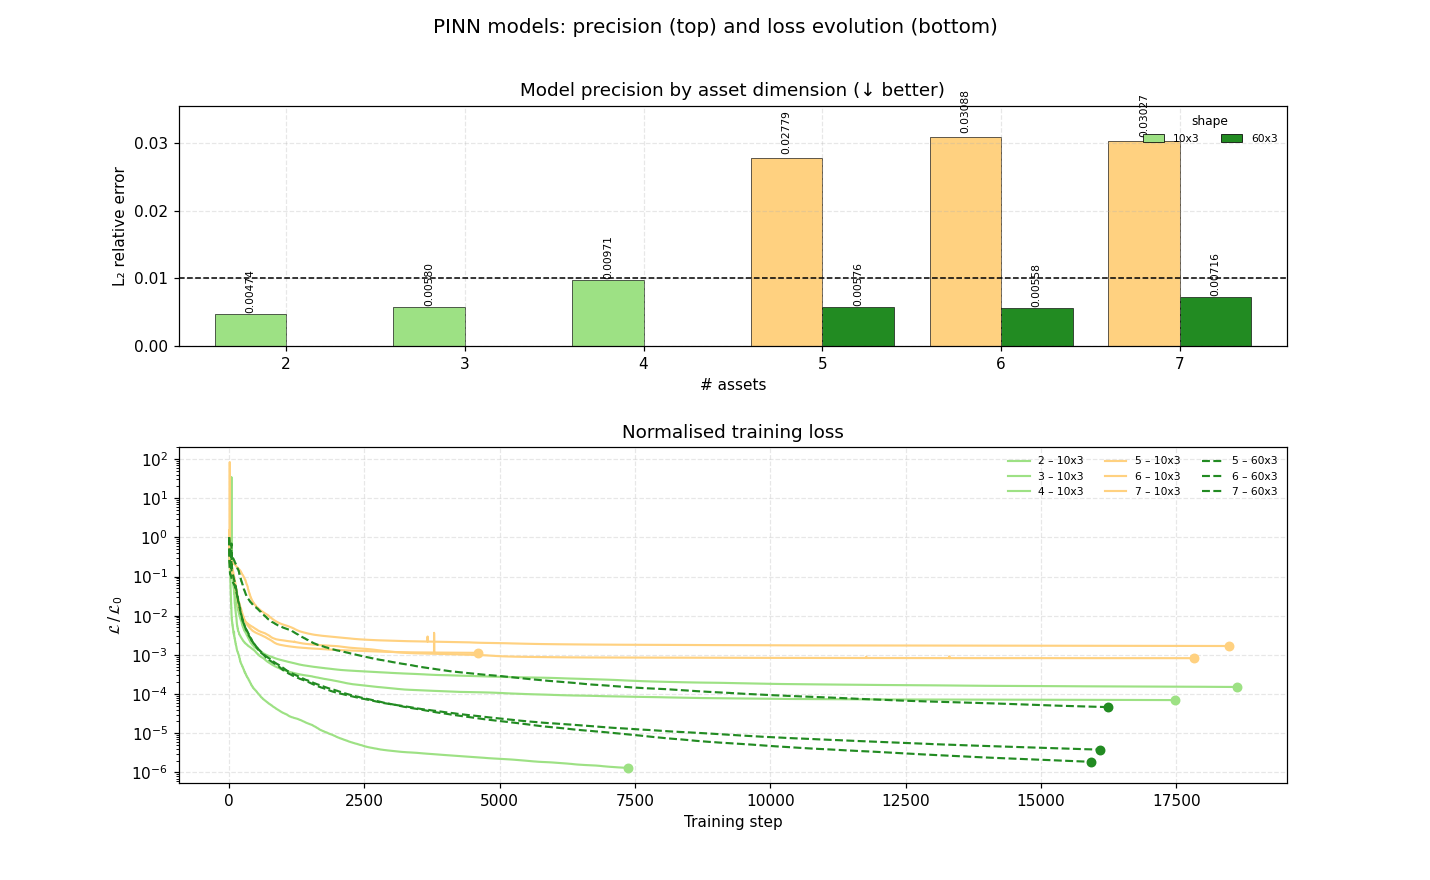

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch                        # already imported earlier

# ------------------------------------------------------------------
# Helper functions needed by the plotting code.
# Define them only if they are not already present in the namespace.
# ------------------------------------------------------------------
try:
    _parse_key
except NameError:
    def _parse_key(k: str):
        """
        >>> _parse_key("pinn_10x3_7")
        (7, '10x3')
        """
        _, shape, n = k.split("_")
        return int(n), shape

try:
    _nice_label
except NameError:
    def _nice_label(k: str) -> str:
        n, shape = _parse_key(k)
        return f"{n} – {shape}"   # e.g. "7 – 10x3"


# ───────────────────────────── configuration ────────────────────────────
THRESH = 1e-2                       # 1 % precision cut-off
COLORS = {                          # base colours
    "good"      : "#228B22",        #     dark green
    "good_10x3" : "#9de184",        # light green
    "bad"       : "#FF8C00",        #     orange
    "bad_10x3"  : "#FFD180",        # light orange
}
LINESTYLES = ["-", "--", ":", "-."] # recycled per model size

mpl.rcParams.update({
    "axes.grid"   : True,
    "grid.linestyle": "--",
    "grid.alpha"  : .3,
})

# ─────────────────────────── precision helpers ──────────────────────────
def _bar_colour(err, shape):
    """Pick a bar colour from the palette given error and model shape."""
    if err < THRESH:
        return COLORS["good_10x3"] if shape == "10x3" else COLORS["good"]
    return COLORS["bad_10x3"] if shape == "10x3" else COLORS["bad"]

# collect every <#assets, shape> we actually have
all_keys     = list(bench)
assets       = sorted({ _parse_key(k)[0] for k in all_keys })
shapes       = sorted({ _parse_key(k)[1] for k in all_keys },
                      key=lambda s: int(s.split("x")[0]))   # sort by width

# map shape → linestyle (cycled)
ls_cycle     = { sh: LINESTYLES[i % len(LINESTYLES)]
                 for i, sh in enumerate(shapes) }

# ────────────────────────────── figure ----------------------------------
fig = plt.figure(figsize=(13, 8), dpi=110)
gs  = fig.add_gridspec(2, 1, height_ratios=[1, 1.4], hspace=.35)
ax_prec = fig.add_subplot(gs[0])   # top  : precisions
ax_loss = fig.add_subplot(gs[1])   # bottom: losses

# ──────────────────────── TOP: precision bars ───────────────────────────
bar_w   = 0.8 / len(shapes)        # width of each individual bar
x_ticks = []                       # keep centres for xtick placement
for i, n_assets in enumerate(assets):
    x_ticks.append(i)
    for j, shape in enumerate(shapes):
        # find the matching checkpoint (if it exists)
        key = next(
            (k for k in bench
             if _parse_key(k) == (n_assets, shape)),
            None
        )
        if key is None:
            continue               # no such model
        err = bench[key]["l2_rel_error"]
        x   = i - 0.4 + bar_w/2 + j*bar_w
        c   = _bar_colour(err, shape)
        bar = ax_prec.bar(x, err, width=bar_w,
                          color=c, edgecolor="black", linewidth=.4)
        # numeric label on top
        txt = f"{err:.2e}" if err < 1e-3 else f"{err:.5f}"
        ax_prec.text(x, err*1.02, txt,
                     ha="center", va="bottom", fontsize=7, rotation=90)

# cosmetic axes tweaks
ax_prec.set_xlim(-0.6, len(assets)-0.4)
ax_prec.set_ylim(0, max(bench[k]["l2_rel_error"] for k in bench)*1.15)
ax_prec.set_xticks(x_ticks)
ax_prec.set_xticklabels(assets)
ax_prec.set_ylabel("L₂ relative error")
ax_prec.set_xlabel("# assets")
ax_prec.set_title("Model precision by asset dimension (↓ better)")
ax_prec.axhline(THRESH, color="k", lw=1, ls="--")

# legend proxy handles (one per shape)
from matplotlib.patches import Patch
handles = [Patch(facecolor=_bar_colour(0.0, sh),
                 edgecolor='black', linewidth=.5,
                 label=sh) for sh in shapes]
ax_prec.legend(handles=handles, title="shape", ncol=len(handles),
               fontsize=7, title_fontsize=8, frameon=False,
               loc="upper right")

# ─────────────────────── BOTTOM: loss curves ────────────────────────────
for key in all_keys:                # deterministic order
    raw = np.asarray(bench[key]["losses"], dtype=float)
    if raw.size == 0:
        continue
    norm = raw / max(raw[0], 1e-12)
    n_assets, shape = _parse_key(key)
    ax_loss.plot(norm,
                 lw=1.4,
                 color=_bar_colour(bench[key]["l2_rel_error"], shape),
                 ls=ls_cycle[shape],
                 label=_nice_label(key))
    # mark final point
    last_idx = np.where(~np.isnan(norm))[0][-1]
    ax_loss.scatter(last_idx, norm[last_idx], s=30,
                    color=_bar_colour(bench[key]["l2_rel_error"], shape),
                    zorder=3)

ax_loss.set_yscale("log")
ax_loss.set_xlabel("Training step")
ax_loss.set_ylabel(r"$\mathcal{L}\,/\,\mathcal{L}_0$")
ax_loss.set_title("Normalised training loss")
ax_loss.legend(fontsize=7, ncol=3, frameon=False)

# ────────────────────────────── finish ----------------------------------
fig.suptitle("PINN models: precision (top) and loss evolution (bottom)",
             fontsize=13)
fig.tight_layout()
plt.show()


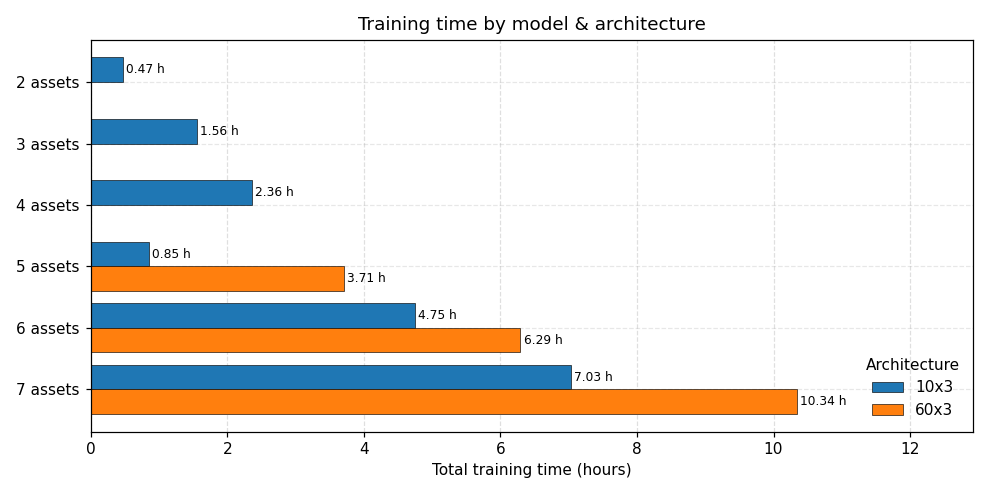

In [41]:
# %% [code]  ––– TRAINING-TIME  (grouped • horizontal • annotated) ––––––––
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------------------
#  1) parse bench keys  →  (n_assets, arch, hours)
# -------------------------------------------------------------------------
def _parse_arch_and_assets(k: str):
    # works for keys like "model_10x2_5"  or  "model_60x3_7"
    _, arch, n = k.split("_")
    return int(n), arch

records = []                 # [(n_assets, arch, hours)]
for k, v in bench.items():
    n_assets, arch = _parse_arch_and_assets(k)
    hours = v["time"] / 3600.0            # sec → hours
    records.append((n_assets, arch, hours))

# -------------------------------------------------------------------------
#  2) axes & helpers
# -------------------------------------------------------------------------
assets_sorted = sorted({r[0] for r in records})          # unique asset counts
arch_list     = sorted({r[1] for r in records})          # unique architectures
y_pos         = np.arange(len(assets_sorted))
bar_height    = 0.8 / max(len(arch_list), 1)             # fit all bars
palette       = plt.get_cmap("tab10")                    # colour set
arch_colors   = {arch: palette(i) for i, arch in enumerate(arch_list)}

fig, ax = plt.subplots(figsize=(9, 4.5), dpi=110)

# -------------------------------------------------------------------------
#  3) draw bars arch-by-arch
# -------------------------------------------------------------------------
for j, arch in enumerate(arch_list):
    hours_per_asset = [
        next((h for a, ar, h in records if a == asset and ar == arch), np.nan)
        for asset in assets_sorted
    ]
    offset = (-0.5 + (j + 0.5) / len(arch_list)) * bar_height * len(arch_list)
    bars = ax.barh(y_pos + offset, hours_per_asset,
                   height=bar_height,
                   color=arch_colors[arch],
                   edgecolor="black", linewidth=.4,
                   label=arch)

    # annotate
    for bar, h in zip(bars, hours_per_asset):
        if np.isnan(h):
            continue
        ax.text(h + 0.05,                          # just to the right
                bar.get_y() + bar.get_height()/2,
                f"{h:.2f} h",
                va="center", ha="left", fontsize=8)

# -------------------------------------------------------------------------
#  4) cosmetics
# -------------------------------------------------------------------------
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{a} assets" for a in assets_sorted])
ax.set_xlabel("Total training time (hours)")
ax.set_title("Training time by model & architecture")
ax.invert_yaxis()                                # smallest asset count on top
ax.set_axisbelow(True)
ax.xaxis.grid(True, linestyle="--", alpha=.4)
ax.legend(title="Architecture", frameon=False)

max_hours = np.nanmax([h for *_, h in records])
ax.set_xlim(0, max_hours * 1.25)                 # room for labels
plt.tight_layout()
plt.show()


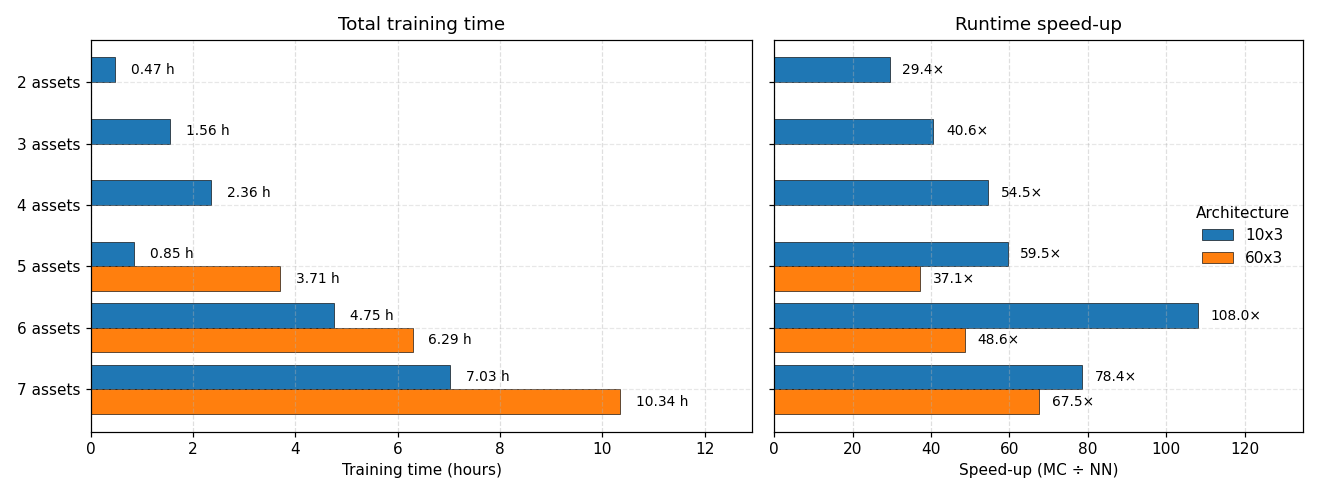

In [42]:
# %% [code] ––– compute missing speed-ups, then plot two aligned panels –––
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------------
# 0) quick benchmark parameters  (small but stable)
# ----------------------------------------------------------------------
TEST_PRICES      = 100
TEST_SIMULATIONS = 50_000          # keep reasonable for notebooks

# -------- helper to parse key → (arch, n_assets) -----------------------
def _arch_n_assets(key: str):
    _, arch, n = key.split("_")
    return arch, int(n)

# -------- helper to (re)build a model exactly as trained ---------------
def _rebuild_model(key: str):
    arch, n_assets = _arch_n_assets(key)
    width, depth   = map(int, arch.lower().split("x"))
    hidden = [width]*depth
    mdl = MLP(in_dim=n_assets+1, hidden_layers=hidden, out_dim=1).to(DEV, DTYPE)
    mdl.load_state_dict(torch.load(f"{key}.pt", map_location=DEV))
    mdl.eval()
    return mdl, n_assets

# -------- fill in missing timing fields --------------------------------
for k, v in bench.items():
    # if {"speedup_x", "nn_ms", "mc_ms"}.issubset(v):
    #     continue                      # already done

    model, n_assets = _rebuild_model(k)
    params          = asset_to_params[n_assets]

    cmp = benchmark_compare_with_mc(
        model, params,
        n_prices      = TEST_PRICES,
        n_simulations = TEST_SIMULATIONS,
        n_runs        = 5,            # a few repeats for stability
        warmup        = 1,
        seed          = 123
    )

    nn_ms = cmp["nn"].mean()*1e3
    mc_ms = cmp["mc"].mean()*1e3
    speed = mc_ms / nn_ms
    v.update(dict(nn_ms=nn_ms, mc_ms=mc_ms, speedup_x=speed))

# ----------------------------------------------------------------------
# 1) build plotting records
# ----------------------------------------------------------------------
records = [(arch, n_assets, v["time"]/3600.0, v["speedup_x"])
           for k, v in bench.items()
           for arch, n_assets in [_arch_n_assets(k)]]

assets_sorted = sorted({n for _, n, *_ in records})
arch_list     = sorted({ar for ar, *_ in records})
palette       = plt.get_cmap("tab10")
arch_colors   = {ar: palette(i) for i, ar in enumerate(arch_list)}

bar_h = 0.80 / max(len(arch_list), 1)
y_pos = np.arange(len(assets_sorted))
FONT_KW = dict(fontsize=9)
DX_FRAC = 0.03                # 3 % offset

fig, (ax_time, ax_speed) = plt.subplots(
    1, 2, figsize=(12, 4.5), dpi=110,
    gridspec_kw={"width_ratios": [1.25, 1]}
)

# ---------------------------------------------------------------- TIME PANEL
max_hours = max(h for *_, h, _ in records)
for j, arch in enumerate(arch_list):
    hrs = [next((h for ar2,a2,h,_ in records if ar2==arch and a2==a), np.nan)
           for a in assets_sorted]
    off = (-0.5 + (j+0.5)/len(arch_list))*bar_h*len(arch_list)
    bars = ax_time.barh(y_pos+off, hrs, height=bar_h,
                        color=arch_colors[arch], edgecolor="black", lw=.4)
    for bar, h in zip(bars, hrs):
        if np.isnan(h): continue
        ax_time.text(h+DX_FRAC*max_hours, bar.get_y()+bar.get_height()/2,
                     f"{h:.2f} h", ha="left", va="center", **FONT_KW)

ax_time.set_xlim(0, max_hours*1.25)
ax_time.set_xlabel("Training time (hours)")
ax_time.set_title("Total training time")
ax_time.set_yticks(y_pos)
ax_time.set_yticklabels([f"{a} assets" for a in assets_sorted])
ax_time.invert_yaxis()
ax_time.grid(axis="x", ls="--", alpha=.4)

# -------------------------------------------------------------- SPEED PANEL
max_speed = max(s for *_, s in records)
for j, arch in enumerate(arch_list):
    spd = [next((s for ar2,a2,_,s in records if ar2==arch and a2==a), np.nan)
           for a in assets_sorted]
    off = (-0.5 + (j+0.5)/len(arch_list))*bar_h*len(arch_list)
    bars = ax_speed.barh(y_pos+off, spd, height=bar_h,
                         color=arch_colors[arch], edgecolor="black", lw=.4,
                         label=arch)
    for bar, s in zip(bars, spd):
        if np.isnan(s): continue
        ax_speed.text(s+DX_FRAC*max_speed, bar.get_y()+bar.get_height()/2,
                      f"{s:.1f}×", ha="left", va="center", **FONT_KW)

ax_speed.set_xlim(0, max_speed*1.25)
ax_speed.set_xlabel("Speed-up (MC ÷ NN)")
ax_speed.set_title("Runtime speed-up")
ax_speed.set_yticks(y_pos)            # align rows
ax_speed.set_yticklabels([])          # labels only on left axis
ax_speed.invert_yaxis()
ax_speed.grid(axis="x", ls="--", alpha=.4)
ax_speed.legend(title="Architecture", frameon=False, loc="right")

fig.tight_layout()
plt.show()
